In [12]:
import os
import glob
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('./video/*')]
classes.sort()
# some global params
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 5
BS = 8
# pattern to get videos and classes
glob_pattern='./video/{classname}/*.avi'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split=.33, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Warning, `split` argument is replaced by `split_val`, please condider to change your source code.The `split` argument will be removed in future releases.


class eat, validation count: 35, train count: 73
class golf, validation count: 34, train count: 71
class run, validation count: 76, train count: 156
Total data: 3 classes for 300 files for train


In [13]:
valid = train.get_validation_generator()

Total data: 3 classes for 145 files for validation


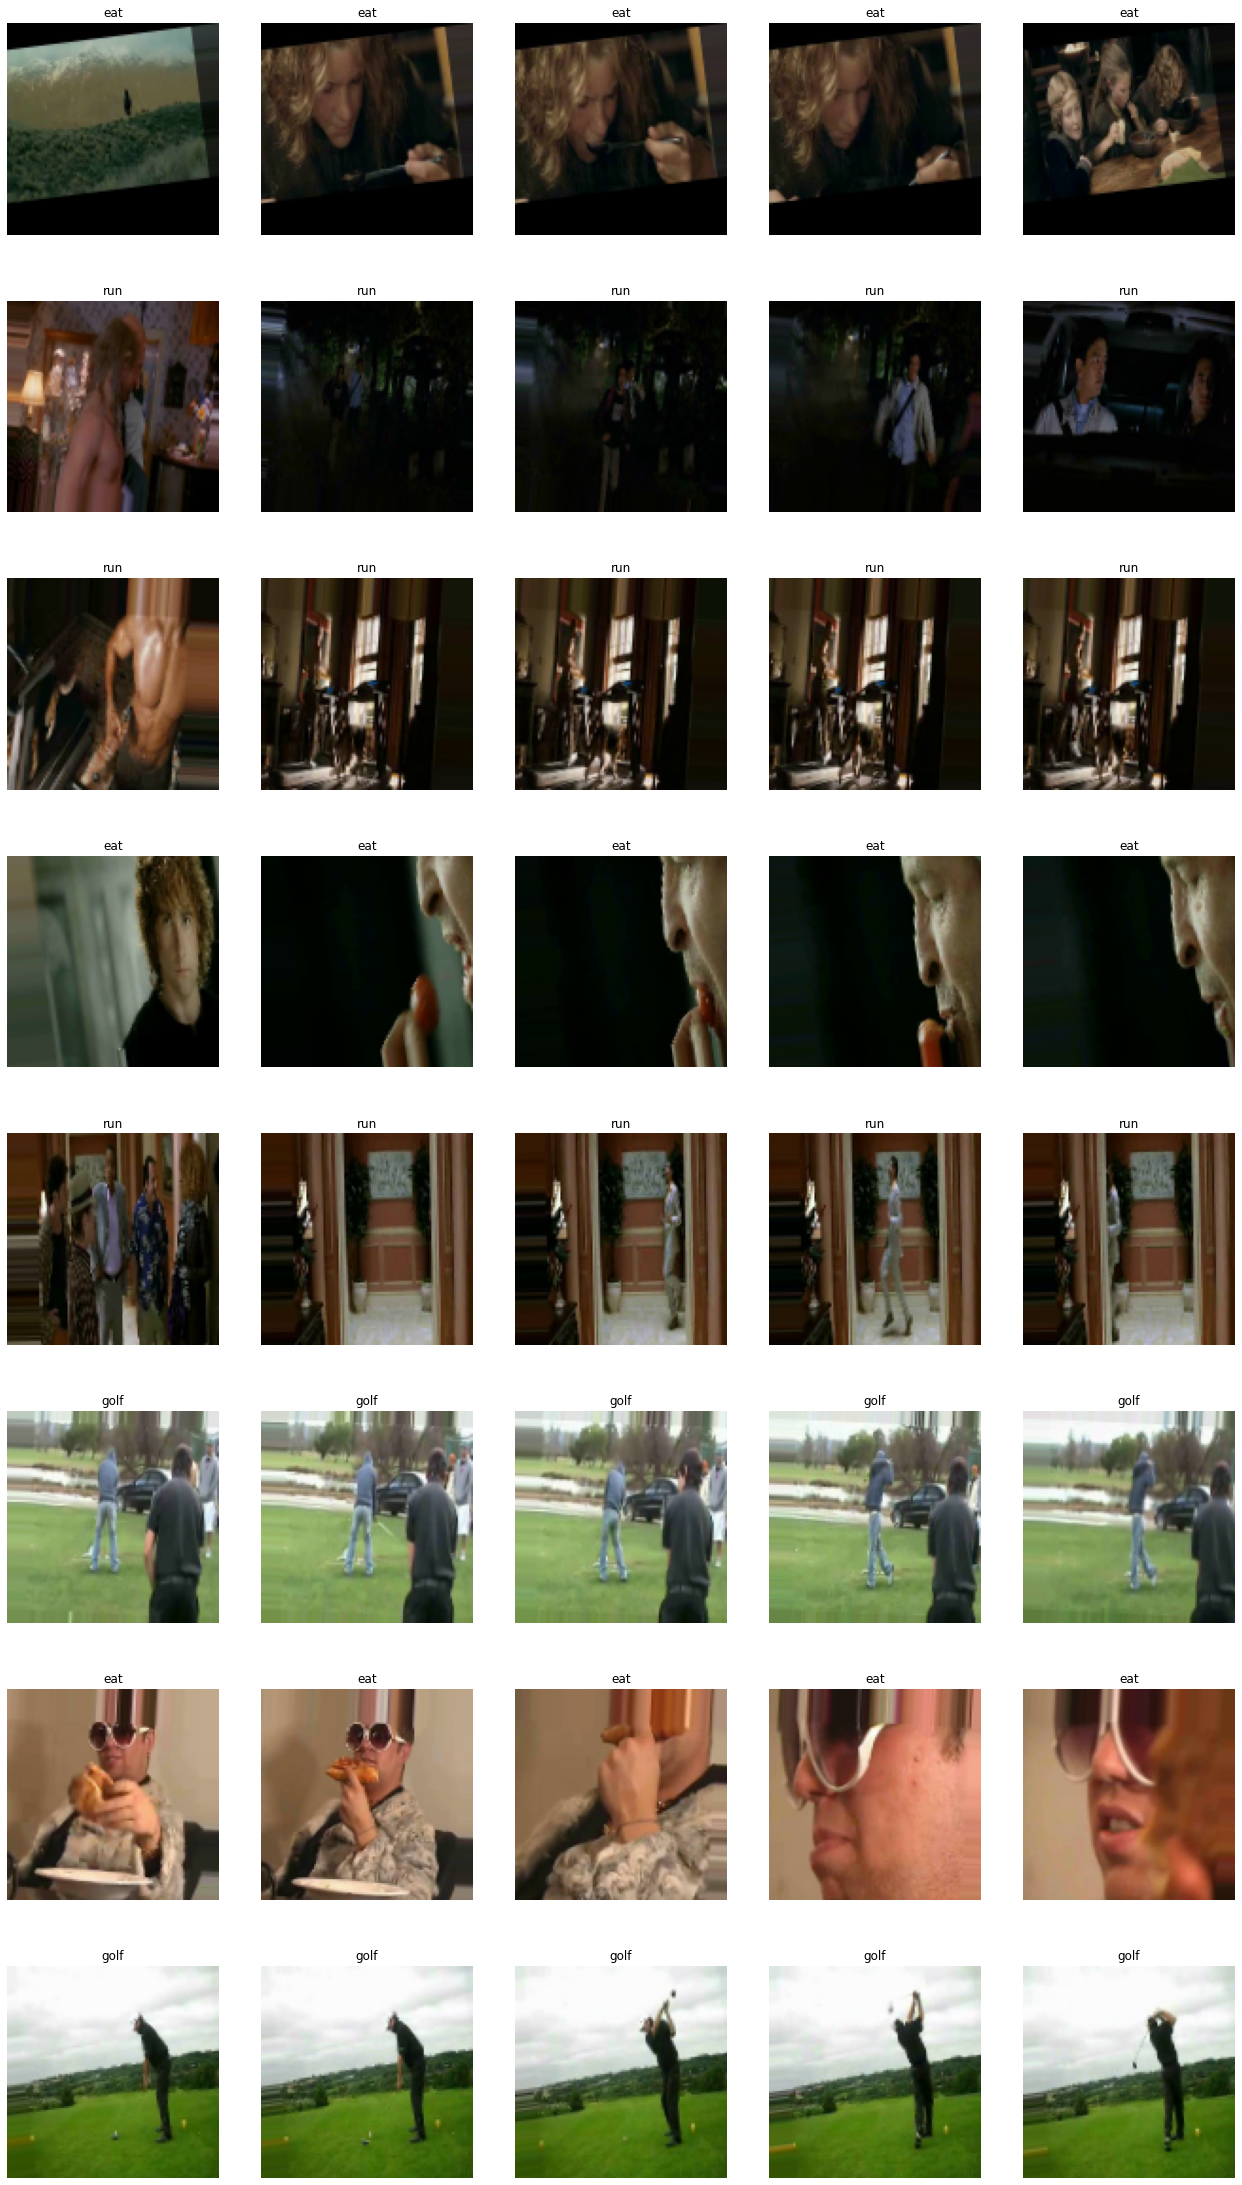

In [14]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [15]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPool2D, GlobalMaxPool2D
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [16]:
from keras.layers import TimeDistributed, GRU, Dense, Dropout
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [17]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

In [18]:
EPOCHS=50
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50
37/37 [==============================] - 191s 5s/step - loss: 1.0902 - acc: 0.3673 - val_loss: 0.8014 - val_acc: 0.6667

Epoch 00001: saving model to chkp\weights.01-0.80.hdf5
Epoch 2/50
37/37 [==============================] - 176s 5s/step - loss: 0.9767 - acc: 0.5173 - val_loss: 0.7974 - val_acc: 0.7014

Epoch 00002: saving model to chkp\weights.02-0.80.hdf5
Epoch 3/50
37/37 [==============================] - 178s 5s/step - loss: 0.8958 - acc: 0.5774 - val_loss: 0.7576 - val_acc: 0.6181

Epoch 00003: saving model to chkp\weights.03-0.76.hdf5
Epoch 4/50
37/37 [==============================] - 177s 5s/step - loss: 0.8828 - acc: 0.5645 - val_loss: 0.7477 - val_acc: 0.6250

Epoch 00004: saving model to chkp\weights.04-0.75.hdf5
Epoch 5/50
37/37 [==============================] - 177s 5s/step - loss: 0.7350 - acc: 0.6302 - val_loss: 0.6969 - val_acc: 0.5278

Epoch 00005: saving model to chkp\weights.05-0.70.hdf5
Epoch 6/50
37/37 [==============================] - 177s 5s/step 

37/37 [==============================] - 201s 5s/step - loss: 0.6605 - acc: 0.6509 - val_loss: 0.4734 - val_acc: 0.7778

Epoch 00044: saving model to chkp\weights.44-0.47.hdf5
Epoch 45/50
37/37 [==============================] - 199s 5s/step - loss: 0.6642 - acc: 0.6747 - val_loss: 0.5111 - val_acc: 0.7431

Epoch 00045: saving model to chkp\weights.45-0.51.hdf5
Epoch 46/50
37/37 [==============================] - 218s 6s/step - loss: 0.6440 - acc: 0.7038 - val_loss: 0.4872 - val_acc: 0.7431

Epoch 00046: saving model to chkp\weights.46-0.49.hdf5
Epoch 47/50
37/37 [==============================] - 216s 6s/step - loss: 0.7301 - acc: 0.6520 - val_loss: 0.5158 - val_acc: 0.7431

Epoch 00047: saving model to chkp\weights.47-0.52.hdf5
Epoch 48/50
37/37 [==============================] - 242s 7s/step - loss: 0.6694 - acc: 0.6539 - val_loss: 0.5098 - val_acc: 0.7292

Epoch 00048: saving model to chkp\weights.48-0.51.hdf5
Epoch 49/50
37/37 [==============================] - 274s 7s/step - loss

In [19]:
def build_mobilenet(shape=(224, 224, 3), nbout=3):
    model = keras.applications.mobilenet.MobileNet(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 9 layers to train﻿﻿
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = keras.GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [20]:
# Set size to 224, 224
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 5
BS = 8

In [21]:
def action_model(shape=(5, 112, 112, 3), nbout=3):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_mobilenet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # ...

In [22]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 224, 224, 3)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD()
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

AttributeError: module 'keras' has no attribute 'GlobalMaxPool2D'